In [22]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

In [23]:
trainData = datasets.MNIST(
    root = "data",
    train = True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

testData = datasets.MNIST(
    root = "data",
    train = False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [24]:
len(trainData), len(testData)

(60000, 10000)

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Text(0.5, 1.0, '5')

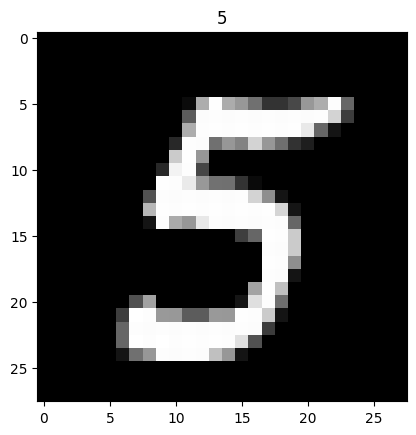

In [26]:
import random
x = random.randint(0, 60000)
image, label = trainData[x]
image.shape
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(label)

In [27]:
from torch.utils.data import DataLoader

train_DataLoader = DataLoader(
                             dataset=trainData,
                             batch_size=32,
                             shuffle = True,
                             )

test_DataLoader = DataLoader(
                             dataset=testData,
                             batch_size=32,
                             shuffle = True,
                             )

In [28]:
class MNISTModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.convBlock1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2,
        )
    )
    self.convBlock2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2,
        )
    )
    # in __init__ after building convBlocks:
    with torch.no_grad():
      dummy = torch.zeros(1, input_shape, 28, 28)
      n_flatten = self.convBlock2(self.convBlock1(dummy)).numel()
    self.Classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(n_flatten, output_shape)
)


  def forward(self, x : torch.Tensor):
    x = self.convBlock1(x)
    x = self.convBlock2(x)
    x = self.Classifier(x)
    return x

In [29]:
from tqdm.auto import tqdm
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


helper_functions.py already exists


In [30]:
from helper_functions import accuracy_fn
from helper_functions import print_train_time
from timeit import default_timer as timer

In [42]:
model = MNISTModel(1, 30, 10).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.1)

In [32]:
def trainLoop(model : nn.Module,
              loss_fn,
              acc_fn,
              optimizer,
              dataloader,
              device = device):
  model.train()
  trainloss = 0
  trainacc = 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    yPred = model(X)
    loss = loss_fn(yPred, y)
    trainloss += loss
    trainacc += accuracy_fn(y_true=y, y_pred=yPred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  trainloss /= len(dataloader)
  trainacc /= len(dataloader)

  print(f"Train loss: {trainloss:.5f} Train acc: {trainacc:.2f}%\n")


In [33]:
def testloop(model : nn.Module,
              loss_fn,
              acc_fn,
              dataloader,
              device = device):
  model.eval()
  testloss, testacc = 0, 0
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      testpred = model(X)
      testloss += loss_fn(testpred, y)
      testacc += accuracy_fn(y_true=y, y_pred=testpred.argmax(dim=1))

    testloss /= len(dataloader)
    testacc /= len(dataloader)

  print(f"Test loss: {testloss:.5f} | Test acc: {testacc:.2f}%\n")


In [49]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  trainLoop(
      model = model,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      optimizer = optimizer,
      dataloader = train_DataLoader
  )
  testloop(
      model = model,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      dataloader = test_DataLoader
  )

train_time_end_on_cpu = timer()

print_train_time(start=train_time_start_on_cpu,
                 end=train_time_end_on_cpu,
                 device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.18197 Train acc: 94.40%

Test loss: 0.05937 | Test acc: 98.14%

Epoch: 1
---------
Train loss: 0.05966 Train acc: 98.16%

Test loss: 0.03683 | Test acc: 98.77%

Epoch: 2
---------
Train loss: 0.04374 Train acc: 98.62%

Test loss: 0.03760 | Test acc: 98.80%


Train time on cuda: 35.078 seconds


35.07830915800014

In [35]:
class LinearModel(nn.Module):
  def __init__(self, inputShape, hiddenUnits, outputShape):
    super().__init__()
    self.layerStack = nn.Sequential(
        nn.Flatten(), # Flatten the input
        nn.Linear(in_features=inputShape, out_features=hiddenUnits),
        nn.ReLU(),
        nn.Linear(in_features=hiddenUnits, out_features=hiddenUnits), # Corrected in_features here
        nn.ReLU(),
        nn.Linear(in_features=hiddenUnits, out_features=outputShape), # Corrected in_features here
    )

  def forward(self, x):
    return self.layerStack(x)

In [36]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

# Create an instance of the LinearModel class
model_linear = LinearModel(inputShape=784, hiddenUnits=20, outputShape=10).to(device)
loss = nn.CrossEntropyLoss()
optimizer_linear = torch.optim.SGD(params=model_linear.parameters(), lr = 0.1)


for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  trainLoop(
      model = model_linear,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      optimizer = optimizer_linear,
      dataloader = train_DataLoader
  )
  testloop(
      model = model_linear,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      dataloader = test_DataLoader
  )

train_time_end_on_cpu = timer()

print_train_time(start=train_time_start_on_cpu,
                 end=train_time_end_on_cpu,
                 device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.45258 Train acc: 86.22%

Test loss: 0.27151 | Test acc: 91.90%

Epoch: 1
---------
Train loss: 0.21337 Train acc: 93.65%

Test loss: 0.20612 | Test acc: 93.72%

Epoch: 2
---------
Train loss: 0.17342 Train acc: 94.74%

Test loss: 0.17892 | Test acc: 94.57%


Train time on cuda: 33.678 seconds


33.67762854400007

In [38]:
trainData2 = datasets.FashionMNIST(
    root = "data",
    train = True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

testData2 = datasets.FashionMNIST(
    root = "data",
    train = False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [52]:
train_DataLoader2 = DataLoader(
                             dataset=trainData2,
                             batch_size=32,
                             shuffle = True,
                             )

test_DataLoader2 = DataLoader(
                             dataset=testData2,
                             batch_size=32,
                             shuffle = True,
                             )

In [53]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

# Create an instance of the LinearModel class
model_linear = LinearModel(inputShape=784, hiddenUnits=20, outputShape=10).to(device)
loss = nn.CrossEntropyLoss()
optimizer_linear = torch.optim.SGD(params=model_linear.parameters(), lr = 0.1)


for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  trainLoop(
      model = model_linear,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      optimizer = optimizer_linear,
      dataloader = train_DataLoader2
  )
  testloop(
      model = model_linear,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      dataloader = test_DataLoader2
  )

train_time_end_on_cpu = timer()

print_train_time(start=train_time_start_on_cpu,
                 end=train_time_end_on_cpu,
                 device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.64947 Train acc: 75.91%

Test loss: 0.46741 | Test acc: 83.27%

Epoch: 1
---------
Train loss: 0.44841 Train acc: 83.56%

Test loss: 0.48464 | Test acc: 81.18%

Epoch: 2
---------
Train loss: 0.41138 Train acc: 84.94%

Test loss: 0.45423 | Test acc: 83.30%


Train time on cuda: 29.783 seconds


29.783075912999948

In [54]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 4

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  trainLoop(
      model = model,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      optimizer = optimizer,
      dataloader = train_DataLoader2
  )
  testloop(
      model = model,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      dataloader = test_DataLoader2
  )

train_time_end_on_cpu = timer()

print_train_time(start=train_time_start_on_cpu,
                 end=train_time_end_on_cpu,
                 device=device)


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.45746 Train acc: 83.51%

Test loss: 0.39971 | Test acc: 85.75%

Epoch: 1
---------
Train loss: 0.33437 Train acc: 87.83%

Test loss: 0.36251 | Test acc: 87.17%

Epoch: 2
---------
Train loss: 0.30182 Train acc: 89.15%

Test loss: 0.35384 | Test acc: 87.49%

Epoch: 3
---------
Train loss: 0.28244 Train acc: 89.84%

Test loss: 0.31021 | Test acc: 88.89%


Train time on cuda: 46.483 seconds


46.48293313399995

In [67]:
model2 = MNISTModel(1, 30, 10).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr = 0.15)

In [68]:
torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 4

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  trainLoop(
      model = model2,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      optimizer = optimizer,
      dataloader = train_DataLoader2
  )
  testloop(
      model = model2,
      loss_fn = loss,
      acc_fn = accuracy_fn,
      dataloader = test_DataLoader2
  )

train_time_end_on_gpu = timer()

print_train_time(start=train_time_start_on_gpu,
                 end=train_time_end_on_gpu,
                 device=device)


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.60319 Train acc: 77.79%

Test loss: 0.40848 | Test acc: 85.29%

Epoch: 1
---------
Train loss: 0.36384 Train acc: 86.75%

Test loss: 0.36978 | Test acc: 86.72%

Epoch: 2
---------
Train loss: 0.32542 Train acc: 88.22%

Test loss: 0.33469 | Test acc: 87.90%

Epoch: 3
---------
Train loss: 0.29879 Train acc: 89.14%

Test loss: 0.32882 | Test acc: 88.22%


Train time on cuda: 47.723 seconds


47.72336968499985